# 1. Data processing

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("./data/skylab_instagram_datathon_dataset.csv", delimiter=";")

# Convert 'date' column to datetime format
df["period_end_date"] = pd.to_datetime(df['period_end_date'], format="%Y-%m-%d")

# Sort DataFrame by 'date' column in ascending order
df = df.sort_values(by='period_end_date', ascending=True)

In [4]:
df = df.rename(columns={"business_entity_doing_business_as_name": "brand", "legal_entity_name": "company", "ultimate_parent_legal_entity_name": "parent_company"})

#### Since we noticed companies have the same number of likes, pictures, followers, videos and comments, we are only using the brand as identifier at first

In [5]:
columns = ["period_end_date", "brand", "followers", "pictures", "videos", "comments", "likes"]
df = df[columns]
df.drop_duplicates(inplace=True)
df.head()

,period_end_date,brand,followers,pictures,videos,comments,likes
77460,2015-01-03,Hering,NaN,21.0,2.0,360.0,20165.0
116410,2015-01-03,Longines,NaN,3.0,NaN,21.0,1361.0
298746,2015-01-03,3.1 Phillip Lim,NaN,5.0,4.0,774.0,28397.0
226467,2015-01-03,Quorn,NaN,14.0,NaN,57.0,557.0
604225,2015-01-03,Proenza Schouler,250681.0,NaN,NaN,NaN,NaN


In [6]:
# We also separete the all brands aggregator from the individual ones
all_brands = df[df["brand"] == "All Brands"]
brands = df[df["brand"] != "All Brands"]

#### We now take care of the data cleaning

In [7]:
# Check the missing values
for column in columns:
    if len(brands[brands[column].isna()]):
        print(f"Column {column} contains na")

Column followers contains na
Column pictures contains na
Column videos contains na
Column comments contains na
Column likes contains na


#### We now check the location of these na (beginning, end or intrusive)

In [8]:
na_intervals = []
columns = ["followers", "comments", "likes", "pictures", "videos"]
brands_names = brands["brand"].unique()

for column in columns:
    for brand in brands_names:
        brand_followers = brands[brands["brand"] == brand][["period_end_date", column]].sort_values("period_end_date")

        # Get the bounds of nan
        start_nan = brand_followers[brand_followers[column].isna()]["period_end_date"].min()
        end_nan = brand_followers[brand_followers[column].isna()]["period_end_date"].max()

        # Get the bounds of not nan
        start_not_nan = brand_followers[brand_followers[column].notna()]["period_end_date"].min()
        end_not_nan = brand_followers[brand_followers[column].notna()]["period_end_date"].max()

        if (pd.isna(start_nan) or pd.isna(end_nan))\
            or (start_nan < start_not_nan and end_nan < start_not_nan)\
            or (start_nan > end_not_nan or end_nan > end_not_nan):
            na_intervals.append({
                "brand": brand,
                "column": column,
                "start": start_nan,
                "end": end_nan,
                "intruisive_na": False
            })
        else:
            na_intervals.append({
                "brand": brand,
                "column": column,
                "start": start_nan,
                "end": end_nan,
                "intruisive_na": True
            })
        

In [9]:
na_intervals_df = pd.DataFrame(na_intervals)
na_intervals_df.head()

,brand,column,start,end,intruisive_na
0,Hering,followers,2015-01-03,2015-04-25,False
1,Longines,followers,2015-01-03,2018-06-02,False
2,3.1 Phillip Lim,followers,2015-01-03,2015-05-02,False
3,Quorn,followers,2015-01-03,2018-03-03,False
4,Proenza Schouler,followers,NaT,NaT,False


In [10]:
na_intrusive_df = na_intervals_df[na_intervals_df["intruisive_na"]]
na_intrusive_df.head()

,brand,column,start,end,intruisive_na
1404,Dysport,comments,2021-01-02,2023-09-16,True


#### We only have one brand with intrusive na so we drop it for simplicity and lack of time

In [11]:
brands = brands[brands["brand"] != "Dysport"]

#### We now check for brands with missing values in the latest periods

In [12]:
year_lag = 4
max_date = brands["period_end_date"].max()
na_brands = na_intervals_df[na_intervals_df["end"] > max_date - pd.DateOffset(years=4)]["brand"].unique()

In [13]:
len(na_brands) / len(brands["brand"].unique())

0.09659090909090909

#### Since the ratio is insignificant and due to lack of time we also ignore these brands

In [14]:
# Clean dataframe
cleaned_brands = brands[brands["period_end_date"] > max_date - pd.DateOffset(years=year_lag)]
cleaned_brands = cleaned_brands[~cleaned_brands["brand"].isin(na_brands)]

# Double check for na
def check_na(df):
    for column in df.columns:
        if df[column].isna().any():
            print(f"Found a NA in {column}")

check_na(cleaned_brands)

# 2. Modelling

## a. Feature Engineering

In [15]:
import numpy as np

def preprocess_data(data):
    """
    Add new features
    """
    data = data[["followers", "likes",  "videos", "pictures", "comments", "period_end_date", "brand"]].copy()
    data['content'] = data['videos'] + data['pictures']
    data['engagement'] = data['likes'] + data['comments']
    # Here we assume data can't have engagement with content = 0
    data['content_engagement'] = np.where((data['content'] != 0) & (data['engagement'] != 0), data['engagement'] / data['content'], 0)
    data = data.drop(["pictures", "followers", "content", "engagement", "videos", "likes", "comments"], axis=1)

    return data

preprocessed_brands = preprocess_data(cleaned_brands)
check_na(preprocessed_brands)

#### We plot the distributions of our target data

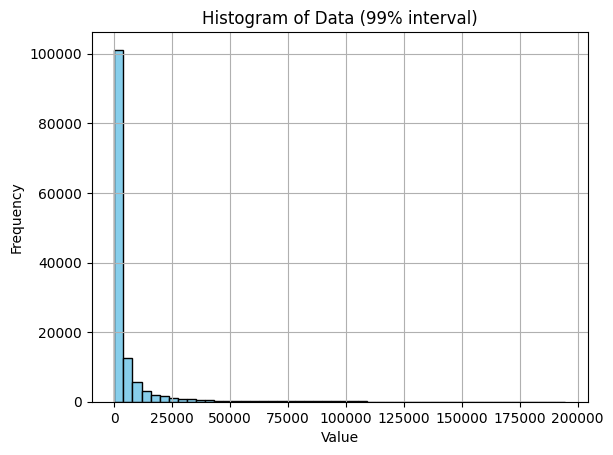

In [16]:
import matplotlib.pyplot as plt

target_data = "content_engagement"

# Calculate the quantiles to determine the range for the histogram
quantiles = preprocessed_brands[target_data].quantile([0.005, 0.999])  # Adjust the quantiles as needed

# Plot the data and the regression line with adjusted limits
plt.hist(preprocessed_brands[target_data], bins=50, range=quantiles, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data (99% interval)')
plt.grid(True)
plt.show()

## 2. a) Machine Learning Model


#### Data preparation

In [17]:
model_data = preprocessed_brands.copy()

In [18]:
from sklearn.preprocessing import LabelEncoder

labelers = []
categorical_data = ["brand"]

for data in categorical_data:
    labeler = LabelEncoder()
    model_data.loc[:, data] = labeler.fit_transform(model_data[data])
    labelers.append(labeler)

check_na(model_data)

In [85]:
previous_target_data = "previous_" + target_data
model_data.loc[:, previous_target_data] = model_data[target_data].shift(1)
# Dropped the first timesteps with no h0 for the LSTM
model_data = model_data.dropna()

In [75]:
# Splitting data
month_of_interests = 3
limit = model_data['period_end_date'].max() - pd.DateOffset(months=month_of_interests)
train_data = model_data[model_data['period_end_date'] < limit]
test_data = model_data[model_data['period_end_date'] >= limit]

check_na(train_data), check_na(test_data)

(None, None)

#### Model LSTM

In [76]:
import numpy as np

# Assuming df is your DataFrame containing the data
# Select relevant columns
features = ["brand", previous_target_data]
target = target_data


# Group the data by (brand, compset, compset_group)
grouped_data = train_data.groupby('brand')

sequences = []
labels = []

for group, group_df in grouped_data:
    
    x = []
    y = []
    for row in group_df.iterrows():
        x.append(([row[1]["brand"], row[1][previous_target_data]]))
        y.append(row[1][target_data])

    sequences.append(x)
    labels.append(y)

In [77]:
filtered_sequences = [s for s in sequences if len(s) == 195]
filtered_labels = [s for s in labels if len(s) == 195]

In [78]:
import numpy as np

# Convert lists to numpy arrays
sequences = np.array(filtered_sequences, dtype=np.float32)
targets = np.array(filtered_labels, dtype=np.float32)

In [79]:
sequences.shape, targets.shape

((636, 195, 2), (636, 195))

In [80]:
from sklearn.preprocessing import StandardScaler

# Extract the second feature from the sequences
second_feature = sequences[:, :, 1]

# Create StandardScaler object for the second feature
scaler_second_feature = StandardScaler()

# Fit and transform the second feature
second_feature_normalized = scaler_second_feature.fit_transform(second_feature)

# Replace the second feature in the original sequences with the normalized values
sequences_normalized = sequences.copy()
sequences_normalized[:, :, 1] = second_feature_normalized


In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(195, 2)))  # Input shape (time_steps, features)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# X_train would be your features shaped into [samples, time_steps, features]
# y_train would be your labels (content_engagement)
model.fit(sequences_normalized, targets_normalized, epochs=20, batch_size=64)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 1.8567
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.8324
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0213
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0203
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0135
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0100
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0084
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0073
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0061
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0052
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0045
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0035
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0022
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0020
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0015
E

In [ ]:
import numpy as np

 
# Initialize an empty array to store the predicted sequences
predicted_sequences = []

# Get the last label of each sequence
last_labels = targets_normalized[:, -1]

# Reshape the last labels to match the model input shape (samples, time_steps, features)
last_labels = last_labels.reshape(-1, 1, 1)

# Generate predictions for the next 30 time steps
for _ in range(30):
    # Predict the next time step based on the last label of each sequence
    next_step_predictions = model.predict(last_labels)
    
    # Append the predicted value to the sequence
    predicted_sequences.append(next_step_predictions)
    
    # Update the last label for the next iteration
    last_labels = np.concatenate([last_labels[:, 1:], next_step_predictions.reshape(-1, 1, 1)], axis=1)

# Convert the list of predicted sequences to a numpy array
predicted_sequences = np.array(predicted_sequences)

# Reshape the predicted sequences to match the original data shape
predicted_sequences = predicted_sequences.reshape(predicted_sequences.shape[0], predicted_sequences.shape[1])

# Inverse transform the predicted sequences if needed (e.g., if you scaled the target variable during normalization)
predicted_sequences = scaler_targets.inverse_transform(predicted_sequences)

# Now predicted_sequences contains the predicted values for the next 30 time steps for each sequence
